## Entfernen von Straßentyp "service" 
-----

Wir möchten unser Model auch mit einem Datensatz trainieren in dem der Straßentyp service nicht enthalten ist und die Auswirkungen betrachten.  
Deshalb erstellen wir auch einen Datensatz ohne highway=service  




In [3]:
# Daten wurden schon geladen und sind im Ordner data abgelegt
import os
import pyrosm
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module='pyrosm')

# Verzeichnis-Pfad
directory = "../../data"
file_path = os.path.join(directory, "berlin-latest.osm.pbf")

# OSM-Objekt erstellen
berlin_osm = pyrosm.OSM(file_path)

# Fahrradnetzwerk extrahieren
cycle_net_berlin = berlin_osm.get_network(network_type="cycling")


### Fehlende Werte für surface setzen

In [5]:
import pandas as pd

# Funktion zum Setzen der Standardwerte für die 'surface'-Spalte basierend auf dem 'highway'-Typ
def set_default_surface(row):
    if pd.isna(row['surface']):
        if row['highway'] == 'service':
            return 'paving_stone'
        elif row['highway'] == 'path':
            return 'dirt'
        elif row['highway'] == 'track':
            return 'dirt'
        else:
            return 'paving_stone'
    else:
        return row['surface']

# Anwenden der Funktion auf die DataFrame
cycle_net_berlin['surface'] = cycle_net_berlin.apply(set_default_surface, axis=1)


### doppelte Werte bei surface entfernen

In [6]:
# Nur den ersten Wert der 'surface'-Spalte behalten
cycle_net_berlin['surface'] = cycle_net_berlin['surface'].dropna().apply(lambda x: x.split(';')[0].strip() if isinstance(x, str) else x)

# Berechne die Häufigkeiten der einzelnen Oberflächenwerte
surface_counts = cycle_net_berlin['surface'].value_counts(dropna=False).reset_index()
surface_counts.columns = ['surface', 'Anzahl Strassen']

# Ersetzen von NaN durch "No Data"
surface_counts['surface'] = surface_counts['surface'].fillna('No Data')

# Gesamtzahl der Straßen berechnen
gesamtzahl_strassen = surface_counts['Anzahl Strassen'].sum()

# Anzahl der Straßen ohne surface-Wert (NaN)
anzahl_no_data = surface_counts[surface_counts['surface'] == 'No Data']['Anzahl Strassen'].sum()

# Prozentsatz berechnen
prozent_no_data = (anzahl_no_data / gesamtzahl_strassen) * 100

print(f"Die Gesamtzahl der Straßen ist: {gesamtzahl_strassen}")
print(f"Die Anzahl der Straßen ohne 'surface'-Wert ist: {anzahl_no_data}")
print(f"Prozentualer Anteil der Straßen ohne 'surface'-Wert: {prozent_no_data:.2f}%")

print(surface_counts)

Die Gesamtzahl der Straßen ist: 177849
Die Anzahl der Straßen ohne 'surface'-Wert ist: 0
Prozentualer Anteil der Straßen ohne 'surface'-Wert: 0.00%
                  surface  Anzahl Strassen
0            paving_stone            62143
1                 asphalt            57634
2           paving_stones            18272
3                    sett            12668
4                concrete             8672
5                    dirt             6647
6                  ground             3346
7               compacted             1838
8             fine_gravel             1246
9                   grass              989
10        concrete:plates              581
11                   sand              555
12            cobblestone              539
13                  paved              492
14                unpaved              465
15                 gravel              462
16            grass_paver              372
17                  earth              246
18     unhewn_cobblestone          

### surface Werte in Kategorien zusammenfassen

In [7]:
# Mapping-Funktion für die Kategorisierung der Oberflächen
def categorize_surface(surface):
    asphalt = ['asphalt', 'tartan']
    paving_stone = ['paving_stone', 'paving_stone:lane', 'paving_stone:20', 'paving_stone:30', 'paved', 'brick', 'metal']
    sett = ['cobblestone', 'unhewn_cobblestone', 'cobblestone:flattened']
    concrete = ['concrete', 'concrete:plates', 'concrete:lanes']
    
    if surface in asphalt:
        return 'asphalt'
    elif surface in paving_stone:
        return 'paving_stone'
    elif surface in sett:
        return 'sett'
    elif surface in concrete:
        return 'concrete'
    else:
        return 'unpaved'

# Neue Spalte für die kategorisierten Oberflächen
cycle_net_berlin['surface_category'] = cycle_net_berlin['surface'].apply(categorize_surface)

# Berechne die Häufigkeiten der einzelnen Kategorien
surface_counts = cycle_net_berlin['surface_category'].value_counts().reset_index()
surface_counts.columns = ['surface_category', 'Anzahl Strassen']

# Gesamtzahl der Straßen berechnen
gesamtzahl_strassen = surface_counts['Anzahl Strassen'].sum()

# Anzahl der Straßen ohne surface-Wert (NaN)
anzahl_no_data = cycle_net_berlin['surface'].isna().sum()

# Prozentsatz berechnen
prozent_no_data = (anzahl_no_data / gesamtzahl_strassen) * 100

print(f"Die Gesamtzahl der Straßen ist: {gesamtzahl_strassen}")
print(f"Die Anzahl der Straßen ohne 'surface'-Wert ist: {anzahl_no_data}")
print(f"Prozentualer Anteil der Straßen ohne 'surface'-Wert: {prozent_no_data:.2f}%")

print(surface_counts)

Die Gesamtzahl der Straßen ist: 177849
Die Anzahl der Straßen ohne 'surface'-Wert ist: 0
Prozentualer Anteil der Straßen ohne 'surface'-Wert: 0.00%
  surface_category  Anzahl Strassen
0     paving_stone            62651
1          asphalt            57637
2          unpaved            47378
3         concrete             9330
4             sett              853


### Überprüfung ob leere Geometrien vorhanden sind

#### Nähere Erläuterungen zum Vorgehen und den Gründen in folgendem notebook [osm_highway](osm_highway.ipynb)

In [8]:
# Finden der leeren Geometrien 
leere_geometrien = cycle_net_berlin[cycle_net_berlin.geometry.is_empty]

print(f"Anzahl der leeren Geometrien: {len(leere_geometrien)}")

Anzahl der leeren Geometrien: 0


In [9]:
# crop to Berlin extent: get administrative boundary from pbf
boundaries = berlin_osm.get_boundaries(name="Berlin")
berlin_boundary = boundaries[boundaries.name=="Berlin"].reset_index().geometry[0]

# intersect with Berlin boundary / Geometrie des Fahrradnetzwerkes innerhalb der Grenzen von Berlin
geom = cycle_net_berlin.intersection(berlin_boundary)

# the intersection only return a geometry - to obtain the rest of the attributes, we need to join the data
# cycle_net_berlin.geometry = geom
cycle_net_berlin.loc[:, 'geometry'] = geom

In [10]:
# Finden der leeren Geometrien 
leere_geometrien = cycle_net_berlin[cycle_net_berlin.geometry.is_empty]

print(f"Anzahl der leeren Geometrien: {len(leere_geometrien)}")

Anzahl der leeren Geometrien: 9968


### Entfernen leerer Geometrien

In [11]:
# Entfernen von leeren Geometrien
cycle_net_berlin = cycle_net_berlin[~cycle_net_berlin.geometry.is_empty]

# Finden der leeren Geometrien 
leere_geometrien = cycle_net_berlin[cycle_net_berlin.geometry.is_empty]

print(f"Anzahl der leeren Geometrien: {len(leere_geometrien)}")

Anzahl der leeren Geometrien: 0


### Entfernen des Straßentyps "service"
---

query: Verwendet eine Zeichenkette zur Angabe der Bedingung. cycle_net_berlin.query("highway != 'service'") gibt nur die Zeilen zurück, bei denen der Wert in der Spalte highway nicht service ist.

In [13]:
import geopandas as gpd


# Entfernen von Straßen vom Typ 'service'
cycle_net_berlin_noservice = cycle_net_berlin.query("highway != 'service'")


#### Überprüfen, ob noch service Straßen vorhanden sind

In [14]:
unique_highway_types = cycle_net_berlin_noservice['highway'].unique()

print("Vorhandene Straßentypen bei 'highway':")
print(unique_highway_types)

Vorhandene Straßentypen bei 'highway':
['residential' 'primary' 'secondary' 'living_street' 'tertiary'
 'unclassified' 'trunk' 'path' 'footway' 'secondary_link' 'cycleway'
 'track' 'pedestrian' 'primary_link' 'tertiary_link' 'construction'
 'steps' 'bridleway' 'busway' 'elevator' 'proposed' 'road' 'street_lamp'
 'services' 'rest_area' 'bus_stop']


In [16]:
cycle_net_berlin_noservice.head(2)

access  area bicycle bicycle_road bridge busway cycleway est_width  foot  \
1   None  None    None         None   None   None     None      None  None   
2   None  None    None         None   None   None     None      None  None   

  footway  ...  turn width       id   timestamp version  \
1    None  ...  None  None  4045194  1698917575      23   
2    None  ...  None  None  4045220  1686491460      51   

                                                tags osm_type  \
1  {"visible":false,"cycleway:both":"no","descrip...      way   
2  {"visible":false,"cycleway:both":"no","lane_ma...      way   

                                            geometry length surface_category  
1  MULTILINESTRING ((13.53136 52.49263, 13.53136 ...  144.0          asphalt  
2  MULTILINESTRING ((13.52694 52.48969, 13.52639 ...   93.0          unpaved  

[2 rows x 42 columns]

### Minimieren des Datensatzes auf relevante Spalten

für die weitere Verarbeitung wollen wir nur die Spalten "geometry" und die neu generierte Spalte "surface_category" behalten.

In [19]:
# Extrahieren der relevanten Spalten 
surfaces = cycle_net_berlin_noservice[['geometry', 'surface_category']]

In [20]:
# verschiedene Straßentypen und deren Häufigkeit im Netzwerk
surface_counts = surfaces['surface_category'].value_counts(normalize=True)*100
surface_counts

surface_category
asphalt         58.032208
unpaved         32.538894
concrete         6.094985
paving_stone     2.743675
sett             0.590238
Name: proportion, dtype: float64

### Speichern des Datensatzes

In [24]:
# Speichern der bereinigten Daten
output_file_name = "../../data/processed_data/cycle_net_berlin_cleaned_surface_noservice.geojson"
surfaces.to_file(output_file_name, driver="GeoJSON")
print(f"Datei erfolgreich als GeoJSON gespeichert unter: {output_file_name}")

Datei erfolgreich als GeoJSON gespeichert unter: ../../data/processed_data/cycle_net_berlin_cleaned_surface_noservice.geojson


### Überprüfung des Datensatzes

In [25]:
# Lade die GeoJSON-Datei
surface_noservice = gpd.read_file("../../data/processed_data/cycle_net_berlin_cleaned_surface_noservice.geojson")
surface_noservice.head(3)

surface_category                                           geometry
0          asphalt  MULTILINESTRING ((13.53136 52.49263, 13.53136 ...
1          unpaved  MULTILINESTRING ((13.52694 52.48969, 13.52639 ...
2          unpaved  MULTILINESTRING ((13.52477 52.48558, 13.52484 ...

### Visualisierung

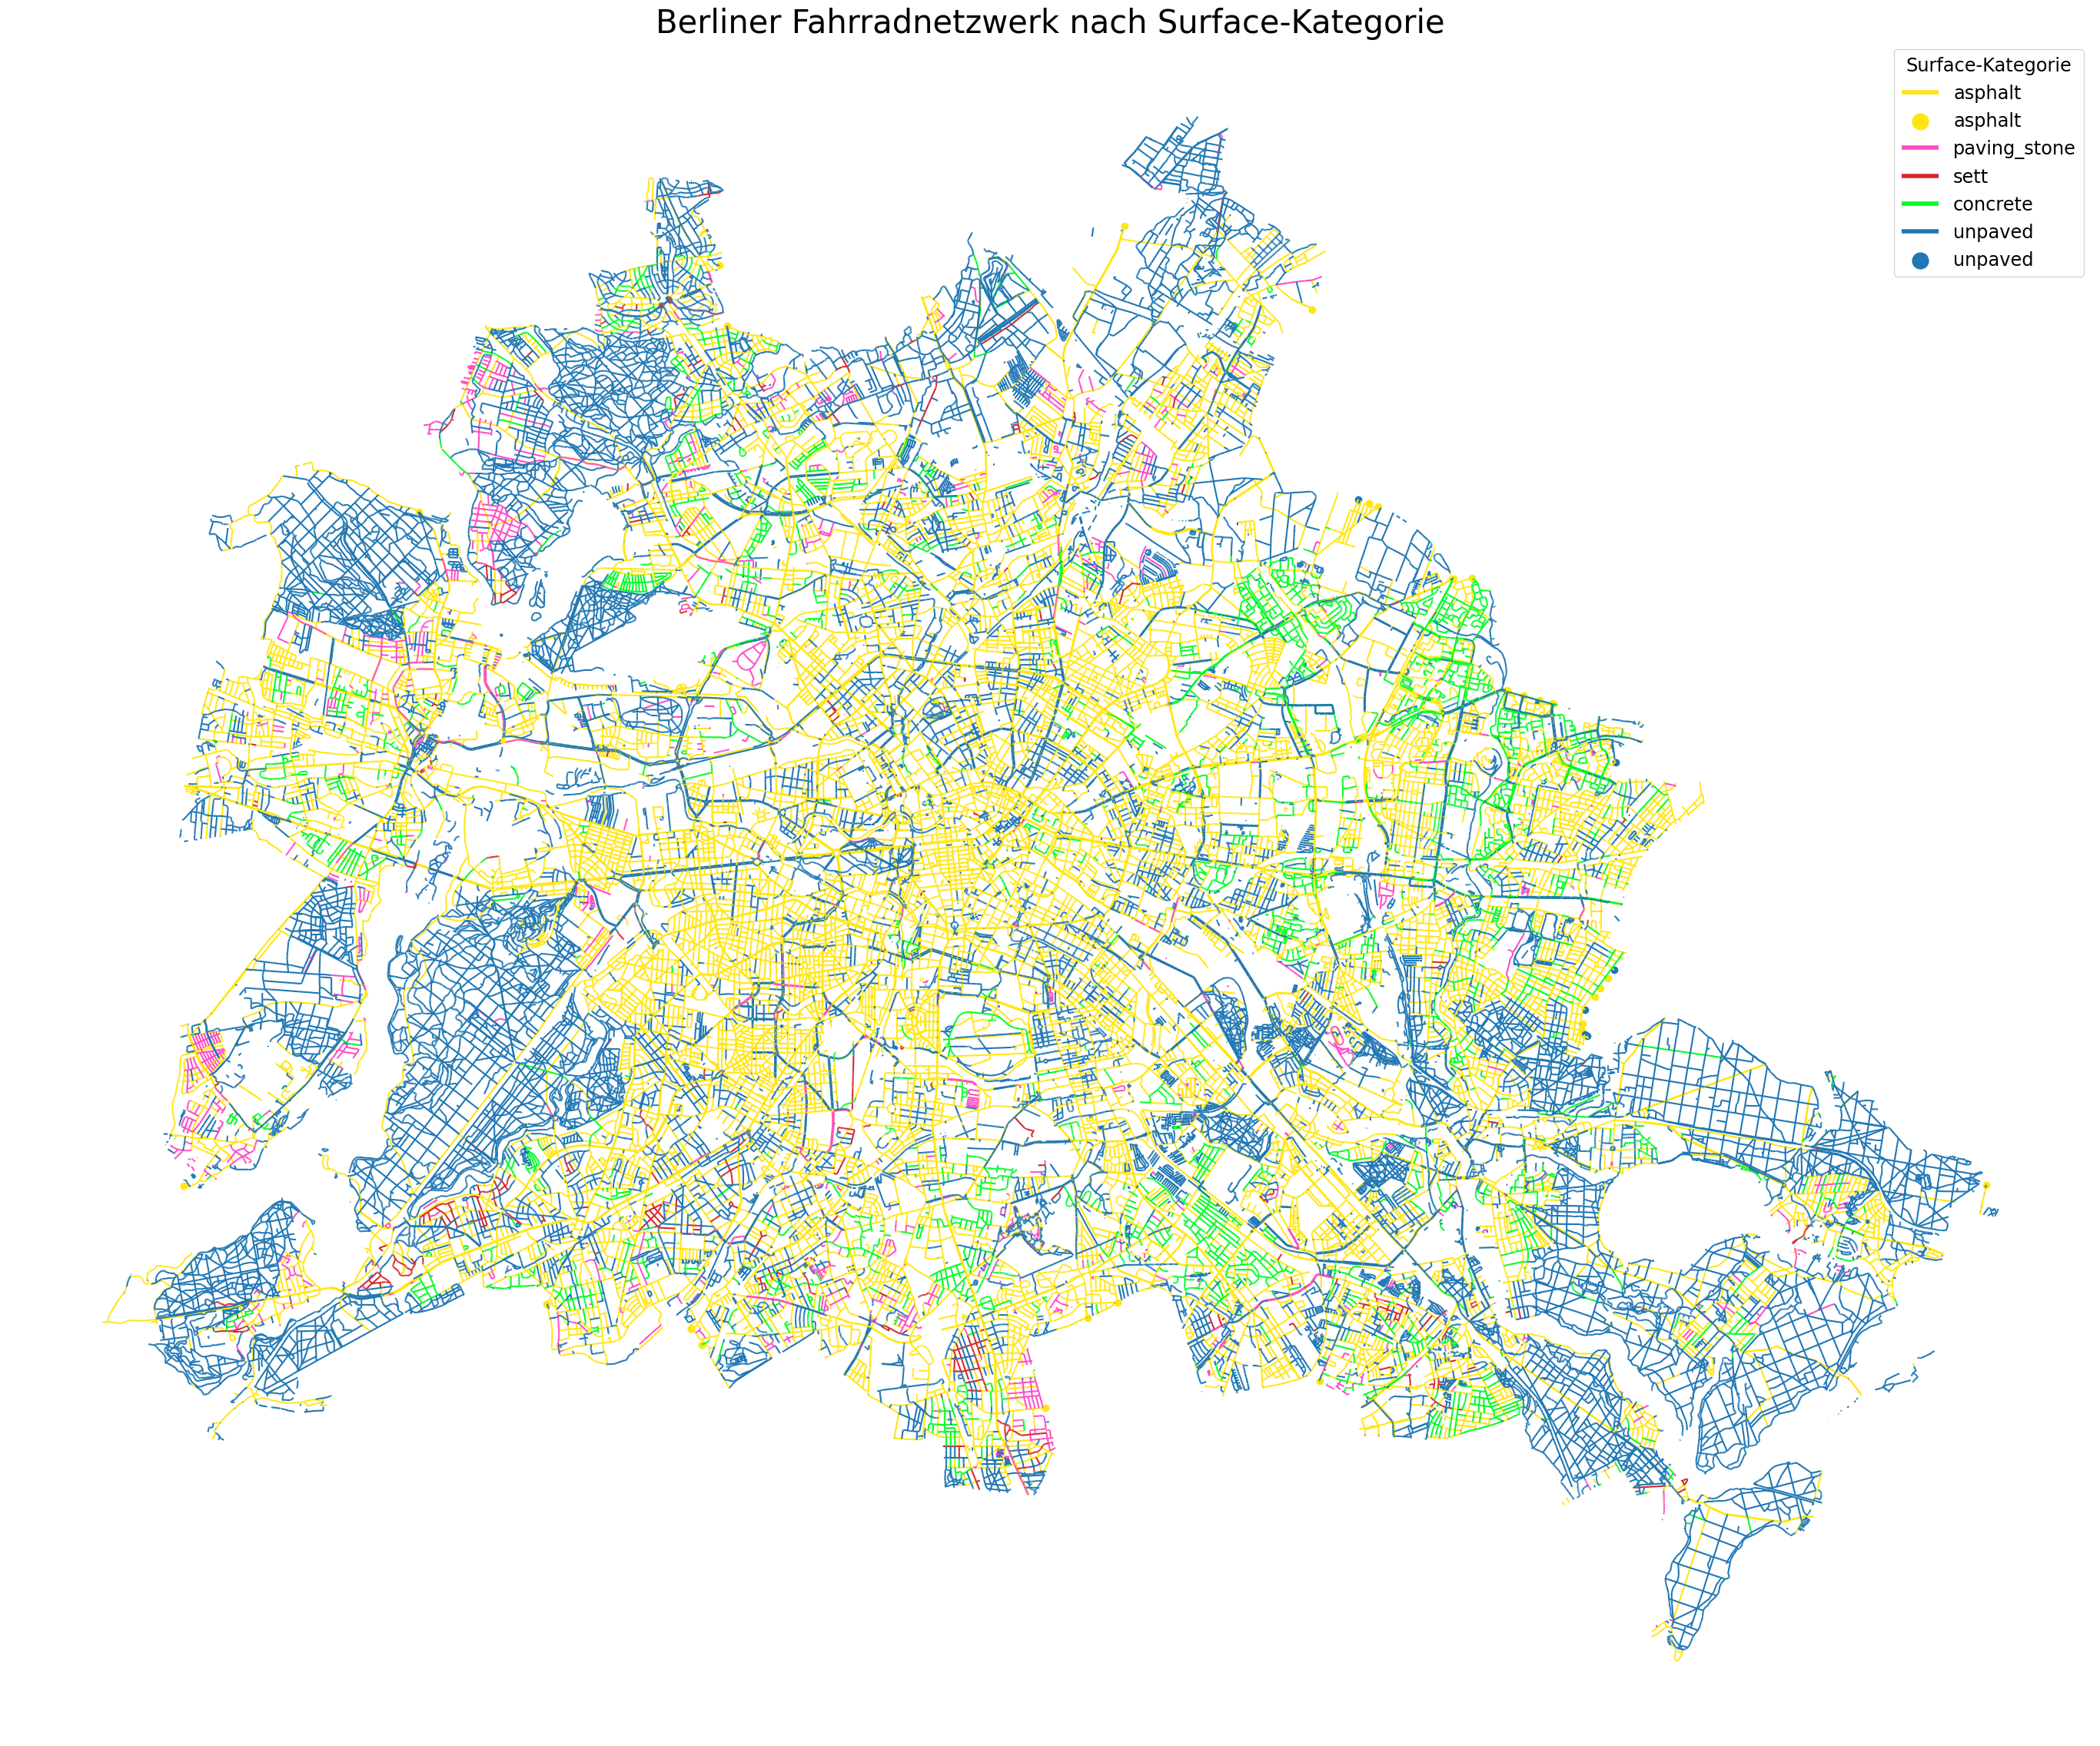

In [27]:
import geopandas as gpd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable


# Definiere ein benutzerdefiniertes Farbschema für die Kategorien
custom_colors = {
    'asphalt': '#ffe611',      # Gelb
    'paving_stone': '#ff4ac6', # Pink
    'sett': '#d62728',         # Rot
    'concrete': '#00fc24',     # Grün
    'unpaved': '#1f77b4'       # Blau
}

# Erstelle eine neue Spalte mit den Farben basierend auf der 'surface_category'
surface_noservice['color'] = surface_noservice['surface_category'].map(custom_colors)

# Visualisiere die Daten
fig, ax = plt.subplots(1, 1, figsize=(35, 35))

# Plotten der GeoDataFrame mit benutzerdefinierten Farben
for category, color in custom_colors.items():
    subset = surface_noservice[surface_noservice['surface_category'] == category]
    subset.plot(ax=ax, color=color, label=category)

# Achsen entfernen
ax.set_axis_off()

# Titel hinzufügen
plt.title('Berliner Fahrradnetzwerk nach Surface-Kategorie', fontsize=30)

# Legende hinzufügen
#plt.legend(title='Surface-Kategorie')

# Legende hinzufügen und anpassen
legend = ax.legend(title='Surface-Kategorie', fontsize='xx-large', title_fontsize='xx-large', loc='upper right', markerscale=2)

# Größe der Legendenmarker anpassen
for legend_handle in legend.legend_handles:  # Verwendung von legend_handles statt legendHandles
    legend_handle.set_linewidth(4.0)

# Plot anzeigen
plt.show()
